# Discrete Anomally Detection

## Exercises


#### Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [56]:
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import  metrics
import  env
from acquire import get_api_logs_data

from wrangle import parse_api_logs_data, value_count_and_proba

In [57]:
df = get_api_logs_data()
df.head()

Getting data from local machine..


,entry
0,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/sales?page=81 HTTP/1.1"" 200 512495 ""-"" ""python-requests/2.21.0"""
1,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/items HTTP/1.1"" 200 3561 ""-"" ""python-requests/2.21.0"""
2,"97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ""GET /api/v1/sales?page=82 HTTP/1.1"" 200 510103 ""-"" ""python-requests/2.21.0"""
3,"97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ""GET /api/v1/sales?page=83 HTTP/1.1"" 200 510003 ""-"" ""python-requests/2.21.0"""
4,"97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ""GET /api/v1/sales?page=84 HTTP/1.1"" 200 511963 ""-"" ""python-requests/2.21.0"""


In [58]:
# Parse the df into user-friendly dataframe

df = df.entry.apply(parse_api_logs_data)
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [59]:
# Create new field of calculated mega bytes and index timestamp

df['size_mb'] = df['size'] / 1024 / 1024

df.timestamp = pd.to_datetime(df.timestamp)

df = df.set_index('timestamp')
df.head(3)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472


## Detecting Anomalies in Discrete Variables --> ip address example
- Methods:
    - Count (# times unique value appears)
    - Frequencies (# times each unique value appears in df as % of total)

In [60]:
# Ip value counts (Most frequent)

df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [61]:
# Normalized ip count 

df.ip.value_counts(normalize = True)

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
68.201.219.223    0.001503
70.121.214.34     0.000143
52.87.230.102     0.000143
35.175.171.137    0.000143
54.145.52.184     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
34.229.70.250     0.000072
54.172.14.223     0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
52.91.30.150      0.000072
52.90.165.200     0.000072
45.23.250.16      0.000072
Name: ip, dtype: float64

In [62]:
# IP counts (least frequent)

df.ip.value_counts().tail(10)

54.145.52.184    1
3.92.201.136     1
35.174.209.2     1
34.229.70.250    1
54.172.14.223    1
34.207.64.242    1
3.88.129.158     1
52.91.30.150     1
52.90.165.200    1
45.23.250.16     1
Name: ip, dtype: int64

In [63]:
# User agents (most frequent)

df.user_agent.value_counts().head()

python-requests/2.21.0                                                                                           12001
python-requests/2.20.1                                                                                            1911
Mozilla/5.0(Macintosh;IntelMacOSX10_14_4)AppleWebKit/537.36(KHTML,likeGecko)Chrome/73.0.3683.103Safari/537.36       34
Mozilla/5.0(Macintosh;IntelMacOSX10.14;rv:66.0)Gecko/20100101Firefox/66.0                                            8
Slackbot-LinkExpanding1.0(+https://api.slack.com/robots)                                                             7
Name: user_agent, dtype: int64

In [64]:
# Call the function to calculate the value counts and probability for each ip address

ip_df = value_count_and_proba(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


In [65]:
ip_df

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503
...,...,...
34.207.64.242,1,0.000072
3.88.129.158,1,0.000072
52.91.30.150,1,0.000072
52.90.165.200,1,0.000072


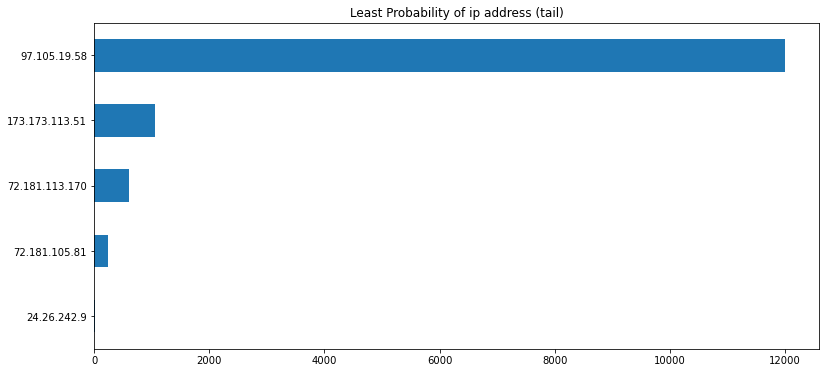

In [66]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(13, 6))
plt.title('Least Probability of ip address (tail)')
None

## Conditional Probalities

In [67]:
# Search for unexpected status code from unknown ip address (proba of 1 == only status code for that ip)

status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize = True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [68]:
# Get other than 200/OK status code (multiple status code per ip address)

status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [69]:
# With proba status given find less than 1

status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


## Exploring  Other Features in this Dataset --> Request path Example

In [70]:
df.request_path.unique()

array(['/api/v1/sales?page=81', '/api/v1/items', '/api/v1/sales?page=82',
       '/api/v1/sales?page=83', '/api/v1/sales?page=84', '/api/v1/stores',
       '/api/v1/sales?page=85', '/api/v1/sales?page=86', '/',
       '/api/v1/items?page=2', '/api/v1/items?page=3', '/api/v1/sales',
       '/api/v1/sales?page=87', '/api/v1/sales?page=88',
       '/api/v1/sales?page=89', '/api/v1/sales?page=90',
       '/api/v1/sales?page=91', '/api/v1/sales?page=92',
       '/api/v1/sales?page=93', '/api/v1/sales?page=94',
       '/api/v1/sales?page=95', '/api/v1/sales?page=96',
       '/api/v1/sales?page=97', '/api/v1/sales?page=98',
       '/api/v1/sales?page=99', '/api/v1/sales?page=100',
       '/api/v1/sales?page=101', '/api/v1/sales?page=102',
       '/api/v1/sales?page=103', '/api/v1/sales?page=104',
       '/api/v1/sales?page=105', '/api/v1/sales?page=106',
       '/api/v1/sales?page=107', '/documentation',
       '/api/v1/sales?page=108', '/api/v1/sales?page=109',
       '/api/v1/sales?page=110

In [71]:
# Call the function to calculate the value counts and probability for each ip address

path_df = value_count_and_proba(df.request_path)
path_df

,count,proba
/api/v1/sales?page=2,709,0.050737
/api/v1/items,464,0.033205
/api/v1/items?page=2,291,0.020824
/api/v1/items?page=3,219,0.015672
/api/v1/stores,162,0.011593
...,...,...
/api/v1/items?page=0,1,0.000072
/api/v1/stores?page=999,1,0.000072
/api/v1/stores?page=2,1,0.000072
/api/v1/stores?page=666,1,0.000072


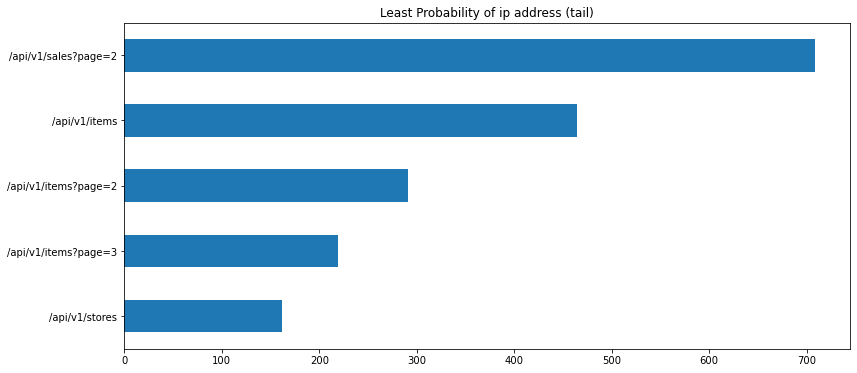

In [72]:
path_df['count'].sort_values().tail(5).plot.barh(figsize=(13, 6))
plt.title('Least Probability of ip address (tail)')
None

In [73]:
# Request method by status code ( 200| 499)
method_given_status_code = (df.groupby('request_method')
                            .status_code.value_counts(normalize = True)
                            .rename('proba_status_given_ip')
                            .reset_index())
method_given_status_code.head()

,request_method,status_code,proba_status_given_ip
0,GET,200,0.998855
1,GET,499,0.001145


In [74]:
# Merge original df to status code by request method
df = df.reset_index().merge(method_given_status_code, on = ['request_method'], how = 'left').fillna(value = 0).set_index('timestamp')

In [75]:
df.head()

,ip,request_method,request_path,http_version,status_code_x,size,user_agent,size_mb,status_code_y,proba_status_given_ip
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,200,0.998855
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,499,0.001145
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,200,0.998855
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,499,0.001145
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,200,0.998855
